In [2]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, average_precision_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve,  confusion_matrix, ConfusionMatrixDisplay, recisionRecallDisplay
from sklearn.manifold import TSNE
from sklearn import preprocessing
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.under_sampling import OneSidedSelection
from imblearn.over_sampling import SMOTE

#import optuna

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
! pip install optuna

In [ ]:
import optuna

# Data Reading

In [3]:
df_credit_card = pd.read_csv('creditcard.csv')

In [8]:
df_credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Data Preprocessing

In [4]:
# The author groups by day, our and amount
# Time
seconds_per_day = 3600*24
df_credit_card["Day"] = df_credit_card["Time"].apply(lambda x: 1 if x<seconds_per_day else 2)
df_credit_card["Hour"] = df_credit_card["Time"].apply(lambda x: (x%seconds_per_day)//3600 + 1)

# Amount
def binning(row, list_columns):
    for i in range(len(list_columns)-1):
        if((row>=list_columns[i])&(row<list_columns[i+1])):
            return "{}-{}".format(list_columns[i], list_columns[i+1])
    return "{}+".format(list_columns[-1])

list_amounts = [0, 5, 10, 50, 100, 500, 1000]
df_credit_card["Amount_Group"] = df_credit_card.apply(lambda x: binning(x["Amount"], list_amounts), axis=1)
list_amounts = ["{}-{}".format(list_amounts[i], list_amounts[i+1]) for i in range(len(list_amounts)-1)]
list_amounts.append("1000+")
dict_amounts = dict(zip(list_amounts, range(len(list_amounts))))

df_credit_card

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Day,Hour,Amount_Group
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1,1.0,100-500
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1,1.0,0-5
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,1.0,100-500
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1,1.0,100-500
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1,1.0,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,2,24.0,0-5
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,2,24.0,10-50
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,2,24.0,50-100
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,2,24.0,10-50


# Exploratory Data Analysis

In [5]:
#Class Distribution
fraud_count = df_credit_card['Class'].value_counts()
fraud_percentage = pd.DataFrame((fraud_count / fraud_count.sum()) * 100)

# Time Distribution of Transactions
time_day_count = df_credit_card.groupby(['Day', 'Hour'])['Time'].count().reset_index()
time_day_count = time_day_count.rename(columns = {'Time': 'Count'})

### Amount Distribution
amount_day_count = df_credit_card.groupby(['Day', 'Amount_Group'])['Amount'].count().reset_index()
amount_day_count = amount_day_count.rename(columns = {'Amount':'Count'})

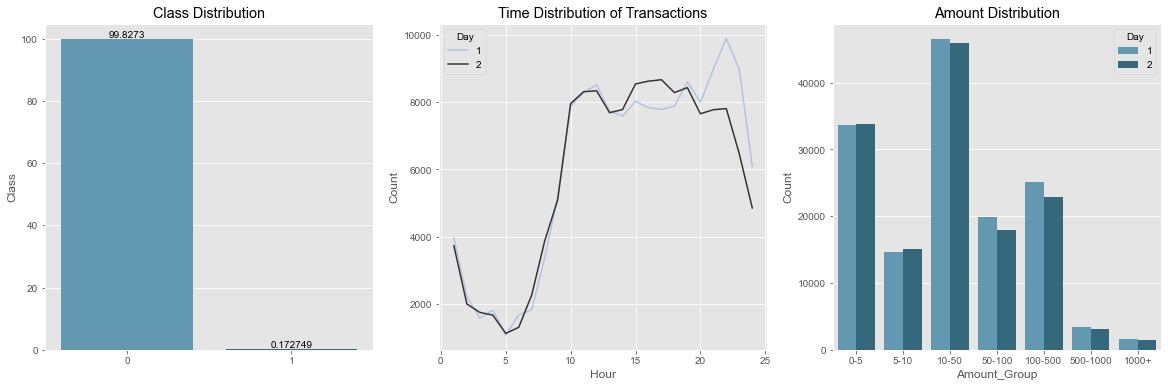

In [6]:
fig, ax = plt.subplots(1,3, figsize = (20, 6))

###
sns.barplot(x = fraud_percentage.index, y = fraud_percentage['Class'], palette = 'PuBuGn_d', ax = ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('Class Distribution')

###
sns.lineplot(data =time_day_count, x = 'Hour', y = 'Count', hue = 'Day', palette = 'PuBuGn_d', ax = ax[1] )
ax[1].set_title('Time Distribution of Transactions')


###
sns.barplot(
    data = amount_day_count,
    x = 'Amount_Group', y = 'Count', 
    hue = 'Day', 
    order = ['0-5', '5-10', '10-50', '50-100', '100-500', '500-1000', '1000+'],  
    palette = 'PuBuGn_d',
    ax = ax[2])

ax[2].set_title('Amount Distribution')
sns.set_style("whitegrid")

# Fraud Transactions by Time

In [8]:
time_day_fraud_count = df_credit_card.groupby(['Day', 'Hour']).agg({'Time': 'count', 'Class' : 'sum'}).reset_index()
time_day_fraud_count = time_day_fraud_count.rename(columns = {'Time': 'Total', 'Class': 'Fraud'})
time_day_fraud_count['Fraud (%)'] = round((time_day_fraud_count['Fraud'] / time_day_fraud_count['Total']) * 100, 2)
time_day_fraud_count.head()

,Day,Hour,Total,Fraud,Fraud (%)
0,1,1.0,3963,2,0.05
1,1,2.0,2217,2,0.09
2,1,3.0,1576,21,1.33
3,1,4.0,1821,13,0.71
4,1,5.0,1082,6,0.55


Text(0.5, 1.0, 'Fraud Transaction by Time')

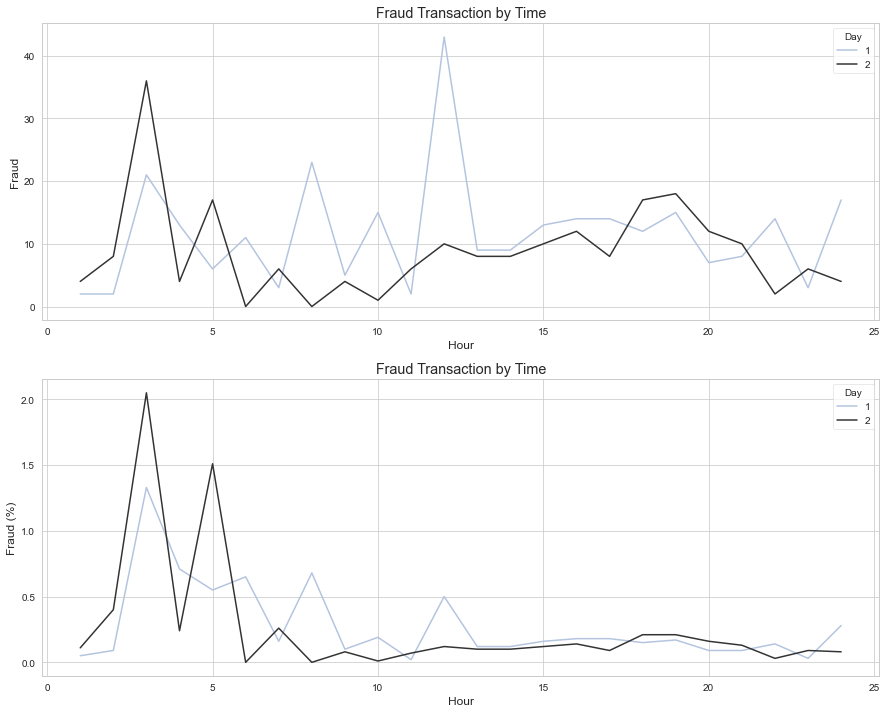

In [9]:
fig, ax = plt.subplots(2,1, figsize = (15,12))

sns.lineplot(x = 'Hour', y = 'Fraud', data = time_day_fraud_count, palette = 'PuBuGn_d', hue =  'Day', ax = ax[0])
ax[0].set_title('Fraud Transaction by Time')

sns.lineplot(x = 'Hour', y = 'Fraud (%)', data = time_day_fraud_count, palette = 'PuBuGn_d', hue =  'Day', ax = ax[1])
ax[1].set_title('Fraud Transaction by Time')

### Fraud Transactions by Amount

In [10]:
amount_day_fraud_count = df_credit_card.groupby(['Day', 'Amount_Group']).agg({'Time':'count', 'Class':'sum'}).reset_index()
amount_day_fraud_count = amount_day_fraud_count.rename(columns = {'Time': 'Total', 'Class':'Fraud'})
amount_day_fraud_count['Fraud (%)'] = round((amount_day_fraud_count['Fraud'] / amount_day_fraud_count['Total']) * 100, 2)

amount_day_fraud_count.head()

,Day,Amount_Group,Total,Fraud,Fraud (%)
0,1,0-5,33701,127,0.38
1,1,10-50,46521,27,0.06
2,1,100-500,25067,55,0.22
3,1,1000+,1598,5,0.31
4,1,5-10,14696,14,0.10


Text(0.5, 1.0, 'Percentage of Fraud Transactions')

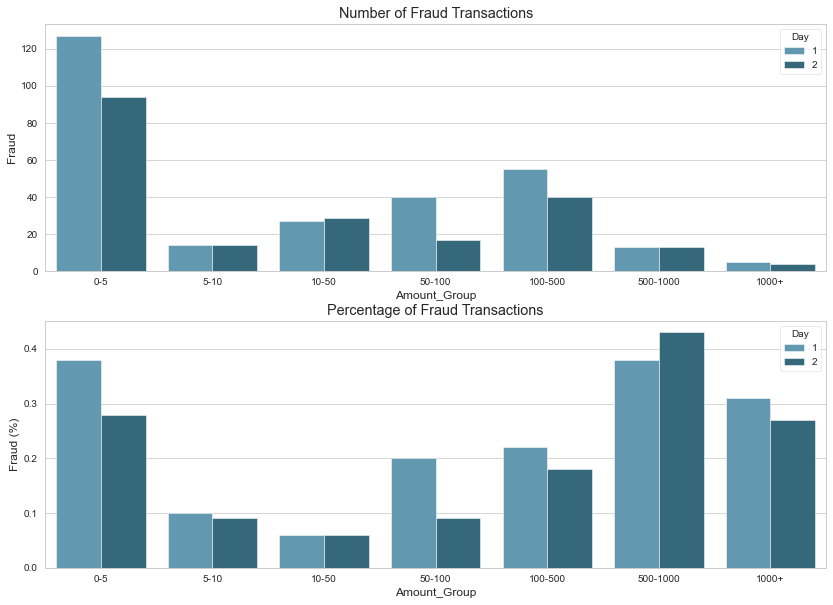

In [11]:
fig, ax = plt.subplots(2,1, figsize = (14, 10))

sns.barplot(
    x = 'Amount_Group', 
    y = 'Fraud', 
    data = amount_day_fraud_count,
    order = ['0-5', '5-10', '10-50', '50-100', '100-500', '500-1000', '1000+'],  
    palette = 'PuBuGn_d',
    hue = 'Day',
    ax = ax[0]
     )
ax[0].set_title('Number of Fraud Transactions')

sns.barplot(
    x = 'Amount_Group', 
    y = 'Fraud (%)', 
    data = amount_day_fraud_count,
    order = ['0-5', '5-10', '10-50', '50-100', '100-500', '500-1000', '1000+'],  
    palette = 'PuBuGn_d',
    hue = 'Day',
    ax = ax[1]
     )
ax[1].set_title('Percentage of Fraud Transactions')

### Pearson and Spearman Correlation Heatmaps

Text(0.5, 1.0, 'Pearsons Correlation')

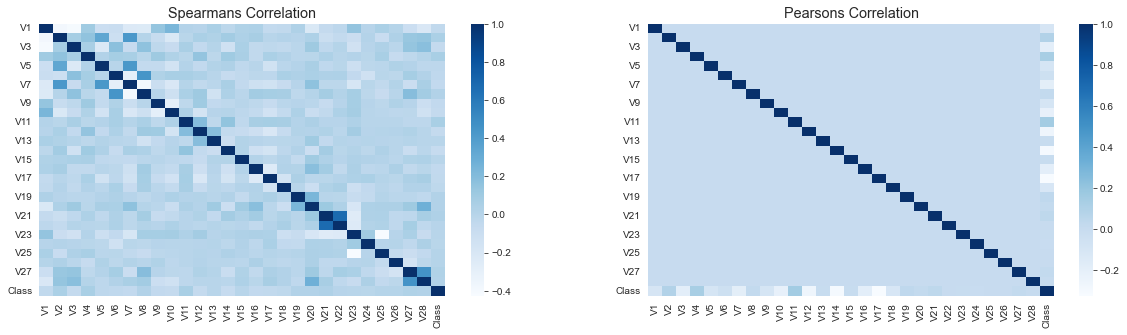

In [12]:
anonymous_feat_labels = df_credit_card.drop(['Time', 'Amount', 'Day', 'Hour', 'Amount_Group'], axis = 1)

fig, ax = plt.subplots(1,2, figsize = (20,5))

sns.heatmap(anonymous_feat_labels.corr(method = 'spearman'), cmap="Blues", ax = ax[0])
ax[0].set_title('Spearmans Correlation')

sns.heatmap(anonymous_feat_labels.corr(), cmap="Blues", ax = ax[1])
ax[1].set_title('Pearsons Correlation')

# Feature Engineering

### Feature Scaling

In [13]:
scaler = RobustScaler()
df_credit_card['Amount_Scaled'] = scaler.fit_transform(df_credit_card['Amount'].values.reshape(-1,1))
df_credit_card['Time_Scaled'] = scaler.fit_transform(df_credit_card['Time'].values.reshape(-1,1))
df_credit_card

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,Day,Hour,Amount_Group,Amount_Scaled,Time_Scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.189115,0.133558,-0.021053,149.62,0,1,1.0,100-500,1.783274,-0.994983
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.125895,-0.008983,0.014724,2.69,0,1,1.0,0-5,-0.269825,-0.994983
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.139097,-0.055353,-0.059752,378.66,0,1,1.0,100-500,4.983721,-0.994972
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.221929,0.062723,0.061458,123.50,0,1,1.0,100-500,1.418291,-0.994972
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.502292,0.219422,0.215153,69.99,0,1,1.0,50-100,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.250034,0.943651,0.823731,0.77,0,2,24.0,0-5,-0.296653,1.034951
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,-0.395255,0.068472,-0.053527,24.79,0,2,24.0,10-50,0.038986,1.034963
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.087371,0.004455,-0.026561,67.88,0,2,24.0,50-100,0.641096,1.034975
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.546668,0.108821,0.104533,10.00,0,2,24.0,10-50,-0.167680,1.034975


### Data Splitting

In [14]:
features = df_credit_card.drop(['Time', 'Amount', 'Day', 'Hour', 'Amount_Group', 'Class'], axis = 1)
labels = df_credit_card['Class']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True, stratify = labels, random_state = 2023)

print('X_train Shape: {}'. format(X_train.shape))
print(' X_test Shape: {}'.format(X_test.shape))
print('y_train Shape: {}'.format(y_train.shape))
print(' y_test Shape: {}'.format(y_test.shape))

print('Labels y_train shape:', Counter(y_train))
print(' Labels y_test Shape:', Counter(y_test))


X_train Shape: (227845, 30)
 X_test Shape: (56962, 30)
y_train Shape: (227845,)
 y_test Shape: (56962,)
Labels y_train shape: Counter({0: 227451, 1: 394})
 Labels y_test Shape: Counter({0: 56864, 1: 98})


# Resampling (OneSidedSelection - SMOTE)

In [18]:
undersample = OneSidedSelection(n_neighbors = 1, n_seeds_S = 200, random_state = 2023)

undersample_X_train, undersample_y_train = undersample.fit_resample(X_train, y_train)

print(undersample_X_train.shape)
print(undersample_y_train.shape)
print('Original dataset shape:' , Counter(y_train))
print('Undersample dataset shape:' , Counter(undersample_y_train))

oversample = SMOTE(sampling_strategy = 0.5, random_state = 2023)
resample_X_train, resample_y_train = oversample.fit_resample(undersample_X_train, undersample_y_train)

print(resample_X_train.shape)
print(resample_y_train.shape)
print('Resample dataset shape:', Counter(resample_y_train))

(26557, 30)
(26557,)
Original dataset shape: Counter({0: 227451, 1: 394})
Undersample dataset shape: Counter({0: 26163, 1: 394})
(39244, 30)
(39244,)
Resample dataset shape: Counter({0: 26163, 1: 13081})


# Fraud Detection

### 4.1. Hyperparameter Tuning (LogisticRegression_Optuna)

In [27]:
def objective_lr(trial):
    # Parameters
    params = {
        'C': trial.suggest_loguniform('C', 1e-7, 1e7),
        'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'random_state': 2023,
        'penalty': 'l2',
    }

    #fit the Model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(resample_X_train, resample_y_train)

    # Make Predictions

    y_pred = optuna_model.predict(X_test)

    # Evaluate Predictions
    auc_pr = average_precision_score(y_test, y_pred)
    return auc_pr

In [28]:
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed = 2023))
study.optimize(objective_lr, n_trials = 50)

[I 2023-01-29 23:32:48,352] A new study created in memory with name: no-name-add8f595-aa5f-442f-a28f-a599df5338ed
[I 2023-01-29 23:32:48,850] Trial 0 finished with value: 0.5989116683872563 and parameters: {'C': 0.003219854565326339, 'tol': 0.0008905320293376914, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5989116683872563.
[I 2023-01-29 23:32:49,036] Trial 1 finished with value: 0.013905425012794978 and parameters: {'C': 9.523073056581953e-06, 'tol': 0.0004684276966825911, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5989116683872563.
[I 2023-01-29 23:32:49,435] Trial 2 finished with value: 0.5365451520132648 and parameters: {'C': 2.194940701351691, 'tol': 0.0005453903035716797, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5989116683872563.
[I 2023-01-29 23:32:49,770] Trial 3 finished with value: 0.5639500008140991 and parameters: {'C': 0.03330885770369032, 'tol': 0.00015202113094260812, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5989116683872563.
[I 202

In [29]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print(' Value: {}'.format(trial.value))
print(' Params: ')

for key, value in trial.params.items():
    print('     {}: {}'.format(key, value))


Number of finished trials: 50
Best trial:
 Value: 0.756133423421843
 Params: 
     C: 1.3236779701996232e-05
     tol: 0.0005142118600947645
     solver: lbfgs


### 4.2 Resampling Evaluation

In [31]:
params = trial.params
best_score = 0
best_resample = {}

n_neighbors = [1, 2, 3, 4, 5]
smote_ratio = [0.35, 0.5, 0.75, 0.8, 1.0]

df_resample = pd.DataFrame()

print('Original dataset shape: ', Counter(y_train))
for i in range(5):
    for j in range(5):
        print('N-Neighbors:', n_neighbors[i], 'Smote Ratio:', smote_ratio[j])
        undersample = OneSidedSelection(n_neighbors = n_neighbors[i], n_seeds_S = 200, random_state = 2023)

        undersample_X_train, undersample_y_train = undersample.fit_resample(X_train, y_train)

        print('Resample dataset shape:', Counter(resample_y_train))

        model = LogisticRegression(random_state = 2023, penalty = 'l2')
        model.set_params(**params)

        model.fit(resample_X_train, resample_y_train)

        # Make Prediction
        y_pred = model.predict(X_test)

        # Evaluate Prediction
        auc_pr = average_precision_score(y_test, y_pred)

        print('Score:', auc_pr)

        df_resample.loc[i*5+j, 'n_neighbors'] = n_neighbors[i]
        df_resample.loc[i*5+j, 'smote_ratio'] = smote_ratio[j]
        df_resample.loc[i*5+j, 'AUC_PR (%)'] = round(auc_pr*100, 2)

        if(auc_pr > best_score):
            best_score = auc_pr
            best_resample['n_neighbors'] = n_neighbors[i]
            best_resample['smote_ratio'] = smote_ratio[j]



Original dataset shape:  Counter({0: 227451, 1: 394})
N-Neighbors: 1 Smote Ratio: 0.35
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 1 Smote Ratio: 0.5
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 1 Smote Ratio: 0.75
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 1 Smote Ratio: 0.8
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 1 Smote Ratio: 1.0
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 2 Smote Ratio: 0.35
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 2 Smote Ratio: 0.5
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 2 Smote Ratio: 0.75
Resample dataset shape: Counter({0: 26163, 1: 13081})
Score: 0.756133423421843
N-Neighbors: 2 Smote Ratio: 0.8
Resample dataset shape

In [32]:
print(best_score, best_resample)
df_resample.head()

0.756133423421843 {'n_neighbors': 1, 'smote_ratio': 0.35}


,n_neighbors,smote_ratio,AUC_PR (%)
0,1.0,0.35,75.61
1,1.0,0.50,75.61
2,1.0,0.75,75.61
3,1.0,0.80,75.61
4,1.0,1.00,75.61


### 4.3 Best Model

In [33]:
undersample = OneSidedSelection(n_neighbors = 1, n_seeds_S = 200, random_state = 2023)
undersample_X_train, undersample_y_train, = undersample.fit_resample(X_train, y_train)

oversample = SMOTE(sampling_strategy = 0.5, random_state = 2023)
resample_X_train, resample_y_train = oversample.fit_resample(undersample_X_train, undersample_y_train)

best_model = LogisticRegression(random_state = 2023, penalty = 'l2')
best_model.set_params(**params)

best_model.fit(resample_X_train, resample_y_train)

y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:,1]

accuracy = round(accuracy_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)
auc_pr = round(average_precision_score(y_test, y_pred), 4)


# 4.4 Visualization

### 4.4.1 Model Performances

In [34]:
# Confusion Matrix
cn_matrix = confusion_matrix(y_test, y_pred)

In [40]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cn_matrix, display_labels = [False, True])

In [ ]:
# Metric Scores
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
scores = [auc_pr, f1, precision, recall, accuracy]
scores = [round(score*100, 2) for score in scores]

metrics = pd.DataFrame(metrics)
scores = pd.DataFrame(scores)
RR = pd.concat([metrics, scores], axis = 1)
RR.columns = ['metrics', 'score']

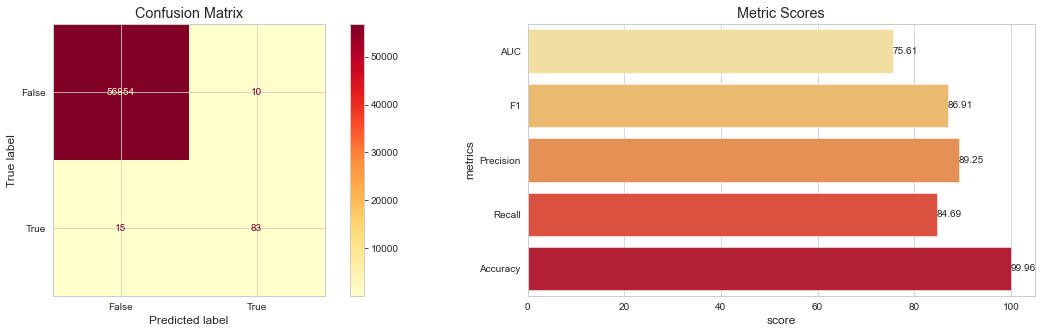

In [86]:
#Model performance
fig, ax = plt.subplots(1,2, figsize = (20,5))

cm_display.plot(cmap=plt.cm.YlOrRd, ax = ax[0])
ax[0].set_title('Confusion Matrix')

sns.barplot(RR['score'], RR['metrics'], orient = 'h', palette = 'YlOrRd', ax = ax[1] )
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('Metric Scores')
plt.show()


In [89]:
# Precision-Recall Curve
precision_c, recall_c, thresholds = precision_recall_curve(y_test, y_score)

Text(0.5, 1.0, 'Precision-Recall Curve')

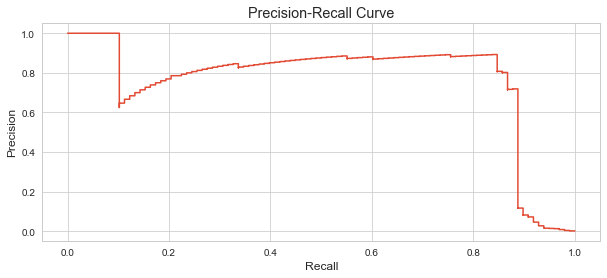

In [106]:
fig, ax = plt.subplots(figsize = (10,4))
pr_display = PrecisionRecallDisplay(precision = precision_c, recall = recall_c).plot(ax = ax)
ax.set_title('Precision-Recall Curve')

### 4.4.2 Feature Importance

In [98]:
# Create DataFrame
df_importance = pd.DataFrame()
importance = best_model.coef_[0]
df_importance["Features"] = features.columns
df_importance["Importance"] = importance
df_importance = df_importance.sort_values(by="Importance", ascending=False).reset_index(drop=True)

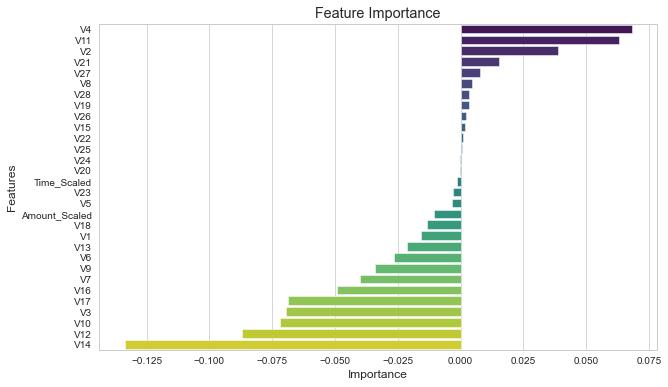

In [105]:
fig, ax = plt.subplots(figsize = (10,6))

sns.barplot(df_importance["Importance"], df_importance["Features"], orient = 'h', palette = 'viridis', ax = ax )
ax.set_title('Feature Importance')
plt.show()
